In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [1]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import re
import numpy as np
import tensorflow as tf
import transformers
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


E0000 00:00:1722823443.641644      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D0805 02:04:03.650037152      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0805 02:04:03.650051959      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0805 02:04:03.650055250      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0805 02:04:03.650057718      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0805 02:04:03.650060219      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

In [4]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:

# Load the data
train_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv')
test_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv')
test_labels = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv')


In [6]:
# Merge and filter test data
merged_test_data = pd.merge(test_data, test_labels, on='id')
filtered_test_data = merged_test_data[(merged_test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] != -1).all(axis=1)]


In [7]:
# Create 'is_toxic' label
filtered_test_data['is_toxic'] = filtered_test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)
train_data['is_toxic'] = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)

/tmp/ipykernel_13/269015839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_data['is_toxic'] = filtered_test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)


In [8]:
# Clean the comment text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = text.strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    cleaned_text = ' '.join(tokens)
    return cleaned_text


In [9]:
train_data['cleaned_comment'] = train_data['comment_text'].apply(clean_text)
filtered_test_data['cleaned_comment'] = filtered_test_data['comment_text'].apply(clean_text)

/tmp/ipykernel_13/1713112218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_data['cleaned_comment'] = filtered_test_data['comment_text'].apply(clean_text)


In [10]:
# Load RoBERTa tokenizer
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize and encode sequences
max_length = 128
X_train = tokenizer.batch_encode_plus(
    train_data['cleaned_comment'].tolist(),
    max_length=max_length,
    padding=True,
    truncation=True,
    return_tensors='tf'
)

X_test = tokenizer.batch_encode_plus(
    filtered_test_data['cleaned_comment'].tolist(),
    max_length=max_length,
    padding=True,
    truncation=True,
    return_tensors='tf'
)

I0000 00:00:1722823575.442950      13 service.cc:145] XLA service 0x583325dbaef0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722823575.443021      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1722823575.443025      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1722823575.443028      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1722823575.443031      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1722823575.443033      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1722823575.443036      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1722823575.443039      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1722823575.443042      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


In [11]:
y_train = train_data['is_toxic'].values
y_test = filtered_test_data['is_toxic'].values

In [12]:

# Initialize TPU strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Number of accelerators:  8


In [13]:
# Load RoBERTa model for sequence classification
from transformers import TFRobertaForSequenceClassification

with strategy.scope():
    model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])


I0000 00:00:1722823607.786902      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.b

In [14]:
# Train the model
history = model.fit(
    [X_train['input_ids'], X_train['attention_mask']],
    y_train,
    epochs=10,
    batch_size=16 * strategy.num_replicas_in_sync,  # Adjust batch size for TPU
    validation_split=0.1
)


Epoch 1/10
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2024-08-05 02:08:09.021342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
I0000 00:00:1722823691.840419     821 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8672ebc37ded9dd0:0:0), session_name()
I0000 00:00:1722823727.468516     821 tpu_compile_op_common.cc:245] Compilation of 8672ebc37ded9dd0:0:0 with session name  took 35.62805307s and succeeded
I0000 00:00:1722823727.556443     821 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8672ebc37ded9dd0:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_9948813518047180959", property.function_library_fingerprint = 16593795787835263893, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, t

1122/1122 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9557

2024-08-05 02:10:58.209540: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
I0000 00:00:1722823858.891180     836 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(e45ea6df7614ee6b:0:0), session_name()
I0000 00:00:1722823863.425681     836 tpu_compile_op_common.cc:245] Compilation of e45ea6df7614ee6b:0:0 with session name  took 4.53445892s and succeeded
I0000 00:00:1722823863.452309     836 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(e45ea6df7614ee6b:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_16489987232587936824", property.function_library_fingerprint = 13810113063080344983, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topolog

1122/1122 [==============================] - 252s 127ms/step - loss: 0.1186 - accuracy: 0.9557 - val_loss: 0.1029 - val_accuracy: 0.9635
Epoch 2/10


I0000 00:00:1722823870.413869     805 tpu_compile_op_common.cc:245] Compilation of 1d2c5998f07d1d9f:0:0 with session name  took 3.975471301s and succeeded
I0000 00:00:1722823870.437537     805 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(1d2c5998f07d1d9f:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_16489987232587936824", property.function_library_fingerprint = 13810113063080344983, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "11,128,;11,128,;11,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722823870.437574     805 tpu_compilation_cache_interface.cc:541] After adding entry for key 1d2c5

1122/1122 [==============================] - 121s 108ms/step - loss: 0.0842 - accuracy: 0.9669 - val_loss: 0.0951 - val_accuracy: 0.9664
Epoch 3/10
1122/1122 [==============================] - 121s 108ms/step - loss: 0.0705 - accuracy: 0.9718 - val_loss: 0.0965 - val_accuracy: 0.9643
Epoch 4/10
1122/1122 [==============================] - 122s 109ms/step - loss: 0.0555 - accuracy: 0.9777 - val_loss: 0.1316 - val_accuracy: 0.9646
Epoch 5/10
1122/1122 [==============================] - 121s 108ms/step - loss: 0.0416 - accuracy: 0.9835 - val_loss: 0.1341 - val_accuracy: 0.9638
Epoch 6/10
1122/1122 [==============================] - 121s 108ms/step - loss: 0.0308 - accuracy: 0.9886 - val_loss: 0.1468 - val_accuracy: 0.9623
Epoch 7/10
1122/1122 [==============================] - 123s 109ms/step - loss: 0.0246 - accuracy: 0.9908 - val_loss: 0.1637 - val_accuracy: 0.9620
Epoch 8/10
1122/1122 [==============================] - 122s 109ms/step - loss: 0.0192 - accuracy: 0.9931 - val_loss: 0.183

2024-08-05 02:29:36.327768: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
I0000 00:00:1722824976.976093     820 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(24e17a35b6c42af2:0:0), session_name()


   8/2000 [..............................] - ETA: 32s   

I0000 00:00:1722824980.507456     820 tpu_compile_op_common.cc:245] Compilation of 24e17a35b6c42af2:0:0 with session name  took 3.531321563s and succeeded
I0000 00:00:1722824980.528550     820 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(24e17a35b6c42af2:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_5340865984647367724", property.function_library_fingerprint = 3341202973760020804, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,128,;4,128,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722824980.528586     820 tpu_compilation_cache_interface.cc:541] After adding entry for key 24e17a35b6

1996/2000 [============================>.] - ETA: 0s

I0000 00:00:1722825011.467198     774 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(a0c212ee7cab8d1c:0:0), session_name()


2000/2000 [==============================] - 48s 17ms/step


I0000 00:00:1722825014.545208     774 tpu_compile_op_common.cc:245] Compilation of a0c212ee7cab8d1c:0:0 with session name  took 3.077965843s and succeeded
I0000 00:00:1722825014.566085     774 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(a0c212ee7cab8d1c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_5340865984647367724", property.function_library_fingerprint = 3341202973760020804, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,128,;2,128,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722825014.566123     774 tpu_compilation_cache_interface.cc:541] After adding entry for key a0c212ee7c

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     57735
           1       0.53      0.89      0.66      6243

    accuracy                           0.91     63978
   macro avg       0.76      0.90      0.81     63978
weighted avg       0.94      0.91      0.92     63978

AUC: 0.965571852183114


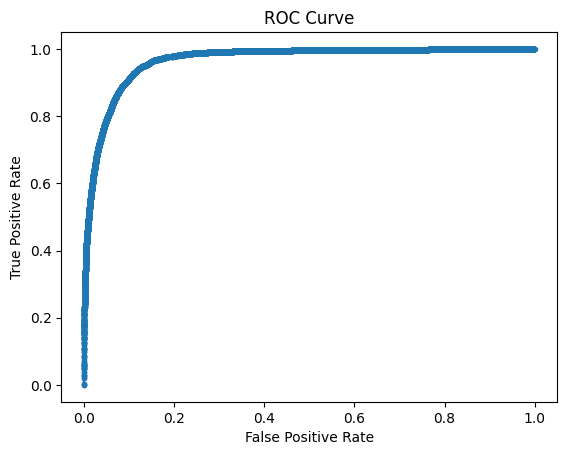

KS Statistic: 0.8190653022161647


In [15]:
# Evaluate the model
y_pred = model.predict([X_test['input_ids'], X_test['attention_mask']]).logits
y_pred_class = (y_pred > 0).astype(int).flatten()

print("Classification Report:")
print(classification_report(y_test, y_pred_class))

# Calculate AUC
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc_score}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# KS statistic
ks_statistic = max(tpr - fpr)
print(f"KS Statistic: {ks_statistic}")


In [ ]:
#to generate the architecture of my implementation
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from transformers import TFRobertaForSequenceClassification

# Initialize TPU strategy if available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("Number of accelerators: ", strategy.num_replicas_in_sync)

# Load the RoBERTa model
with strategy.scope():
    model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1)

# Print the model summary
model.summary()

# Attempt to generate and save a model architecture diagram
try:
    model_keras = tf.keras.Model(inputs=model.input, outputs=model.output)
    plot_model(model_keras, to_file='roberta_model_architecture.png', show_shapes=True, show_layer_names=True)
    print("Model architecture diagram saved as 'roberta_model_architecture.png'.")
except Exception as e:
    print(f"An error occurred: {e}")

# Extracting the model architecture details
model_summary = []
model_keras.summary(print_fn=lambda x: model_summary.append(x))

# Process the summary into a pandas DataFrame
summary_data = []

for layer in model_summary[1:]:  # Skip the first line as it's just the table header
    layer_details = layer.split()
    layer_name = layer_details[0]
    layer_type = layer_details[1]
    output_shape = ' '.join(layer_details[2:-2])  # The output shape may span multiple elements
    num_params = layer_details[-2]
    summary_data.append([layer_name, layer_type, output_shape, num_params])

summary_df = pd.DataFrame(summary_data, columns=["Layer Name", "Layer Type", "Output Shape", "Number of Parameters"])

# Display the DataFrame
print(summary_df)

# Save the DataFrame to a CSV file
summary_df.to_csv('roberta_model_architecture.csv', index=False)


Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Initializing the TPU system: local
free(): corrupted unsorted chunks
https://symbolize.stripped_domain/r/?trace=7971092ade2c,79710925f04f,583329cf1d4f,583329cf1d4f&map= 
*** SIGABRT received by PID 13 (TID 846) on cpu 5 from PID 13; stack trace: ***
PC: @     0x7971092ade2c  (unknown)  (unknown)
    @     0x797016a90387        928  (unknown)
    @     0x79710925f050       9808  (unknown)
    @     0x583329cf1d50  (unknown)  (unknown)
    @     0x583329cf1d50  (unknown)  (unknown)
https://symbolize.stripped_domain/r/?trace=7971092ade2c,797016a90386,79710925f04f,583329cf1d4f,583329cf1d4f&map= 
E0805 02:30:18.747122     846 coredump_hook.cc:442] RAW: Remote crash data gathering hook invoked.
E0805 02:30:18.747134     846 client.cc:269] RAW: Coroner client retries enabled (b/136286901), will retry for up to 30 sec.
E0805 02:30:18.747138     846 coredump_hook.cc:537] RAW: Sending fingerprint to remote end.
E0805 02:30:18.747165     846 coredump_hook.cc:546] RAW: Cannot send 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_roberta_architecture():
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define colors
    colors = {
        'Input Embeddings': '#DCE775',
        'Encoder Layers': '#FFEB3B',
        'Pooling Layer': '#81C784',
        'Classification Head': '#64B5F6'
    }
    
    # Draw layers
    layers = [
        ('Input Embeddings', 1, 5),
        ('Encoder Layers', 2, 5),
        ('Pooling Layer', 3, 1),
        ('Classification Head', 4, 1)
    ]

    for (name, x, y) in layers:
        rect = patches.FancyBboxPatch((x, y), 1, 1, boxstyle="round,pad=0.1", edgecolor='black', facecolor=colors[name])
        ax.add_patch(rect)
        ax.text(x + 0.5, y + 0.5, name, fontsize=12, ha='center', va='center')

    # Add arrows
    arrows = [
        ((1.5, 5.5), (2.5, 5.5)),
        ((2.5, 4.5), (3.5, 2)),
        ((3.5, 1.5), (4.5, 1.5))
    ]
    
    for (start, end) in arrows:
        ax.annotate("", xy=end, xytext=start, arrowprops=dict(arrowstyle="->", lw=2))

    ax.set_xlim(0, 6)
    ax.set_ylim(0, 6)
    ax.set_aspect('equal')
    ax.axis('off')
    
    plt.title('RoBERTa Architecture')
    plt.show()

draw_roberta_architecture()


In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from tabulate import tabulate

# Load model and tokenizer
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Define the table data based on your implementation
table_data = [
    ["Layer", "Description", "Input", "Output"],
    ["Input Embeddings", 
     "Converts token IDs into dense vectors with positional and segment embeddings.",
     "Token IDs, Attention Mask", 
     "Embedded Token Vectors"],
    ["RoBERTa Encoder Layers", 
     "Stack of transformer layers with self-attention and feed-forward networks (12 layers for roberta-base).",
     "Embedded Token Vectors", 
     "Contextualized Token Vectors"],
    ["Pooling Layer", 
     "Extracts the [CLS] token representation for classification tasks.",
     "Contextualized Token Vectors", 
     "Aggregated Representation (CLS)"],
    ["Fully Connected Layer", 
     "Maps the aggregated representation to logits for classification.",
     "Aggregated Representation (CLS)", 
     "Logits"],
    ["Softmax Activation", 
     "Converts logits into probabilities for binary classification.",
     "Logits", 
     "Probabilities"]
]

# Create the table
table = tabulate(table_data, headers="firstrow", tablefmt="grid")

# Print the table
print(table)


In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from tabulate import tabulate

# Load model and tokenizer
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Define the table data based on your implementation
table_data = [
    ["Layer", "Description", "Input", "Output"],
    ["Input Embeddings", 
     "Converts token IDs into dense vectors with positional and segment embeddings.",
     "Token IDs, Attention Mask", 
     "Embedded Token Vectors"],
    ["RoBERTa Encoder Layers", 
     "Stack of transformer layers with self-attention and feed-forward networks (12 layers for roberta-base).",
     "Embedded Token Vectors", 
     "Contextualized Token Vectors"],
    ["Pooling Layer", 
     "Extracts the [CLS] token representation for classification tasks.",
     "Contextualized Token Vectors", 
     "Aggregated Representation (CLS)"],
    ["Fully Connected Layer", 
     "Maps the aggregated representation to logits for classification.",
     "Aggregated Representation (CLS)", 
     "Logits"],
    ["Softmax Activation", 
     "Converts logits into probabilities for binary classification.",
     "Logits", 
     "Probabilities"]
]

# Create the table
table = tabulate(table_data, headers="firstrow", tablefmt="grid")

# Save the table to a text file
file_path = '/kaggle/working/roberta_model_architecture.txt'
with open(file_path, 'w') as file:
    file.write(table)

print(f"Table saved to {file_path}")


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.table as tbl

# Define table data
data = [
    ["Input Embeddings", "Converts token IDs into dense vectors with positional and segment embeddings.", "Token IDs, Attention Mask", "Embedded Token Vectors"],
    ["RoBERTa Encoder Layers", "Stack of transformer layers with self-attention and feed-forward networks (12 layers for roberta-base).", "Embedded Token Vectors", "Contextualized Token Vectors"],
    ["Pooling Layer", "Extracts the [CLS] token representation for classification tasks.", "Contextualized Token Vectors", "Aggregated Representation (CLS)"],
    ["Fully Connected Layer", "Maps the aggregated representation to logits for classification.", "Aggregated Representation (CLS)", "Logits"],
    ["Softmax Activation", "Converts logits into probabilities for binary classification.", "Logits", "Probabilities"]
]

# Define table headers
headers = ["Layer", "Description", "Input", "Output"]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))  # Set figure size (width, height)

# Hide the axis
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create a table
table = tbl.table(ax, cellText=data, colLabels=headers, cellLoc='center', loc='center', colColours=['#f2f2f2']*4)

# Adjust table settings
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1, 2, 3])

# Save the figure
plt.savefig('/kaggle/working/model_architecture_table.png', bbox_inches='tight', pad_inches=0.1)

# Show the table (optional)
plt.show()


In [ ]:
pip install graphviz
